import matplotlib as mpl
# ^^^ pyforest auto-imports - don't write above this line
# Spatio-Temporal Feature extraction task

Notebook showing a workflow example implementing the spatio-temporal features proposed by Waldner et al. "automated annual cropland mapping using knowledge-based temporal features", 2015 ISPRS Journal of Photogrammetry and Remote Sensing

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Create-workflow-for-downloading-data" data-toc-modified-id="1.-Create-workflow-for-downloading-data-1">1. Create workflow for downloading data</a></span></li><li><span><a href="#2.-Results-for-original-data" data-toc-modified-id="2.-Results-for-original-data-2">2. Results for original data</a></span><ul class="toc-item"><li><span><a href="#2.1-Temporal-indices-for-various-temporally-stacked-NDVI-features" data-toc-modified-id="2.1-Temporal-indices-for-various-temporally-stacked-NDVI-features-2.1">2.1 Temporal indices for various temporally stacked NDVI features</a></span></li></ul></li><li><span><a href="#3.-Repeat-using-interpolation" data-toc-modified-id="3.-Repeat-using-interpolation-3">3. Repeat using interpolation</a></span></li></ul></div>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from eolearn.core import LoadTask, SaveTask, LinearWorkflow, FeatureType, EOPatch
from eolearn.io import SentinelHubInputTask
from eolearn.features import AddSpatioTemporalFeaturesTask, AddMaxMinTemporalIndicesTask, \
    AddMaxMinNDVISlopeIndicesTask, NormalizedDifferenceIndexTask, CubicInterpolation
from eolearn.mask import AddValidDataMaskTask

from sentinelhub import BBox, CRS, DataSource

## 1. Create workflow for downloading data

This workflow consists of the following EOTasks:
- download data
- calculate NDVI
- create mask of valid data (no clouds, no `NaN`s due to no data)

The cloud masks are downloaded via the `CLM` bands. More info [here](https://docs.sentinel-hub.com/api/latest/#/API/data_access?id=cloud-masks-and-cloud-probabilities).

In [2]:
# download data
add_data_task = SentinelHubInputTask(
    data_source = DataSource.SENTINEL2_L1C, 
    bands_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    time_difference = timedelta(hours=2),
    resolution=20,
    additional_data = [
        (FeatureType.MASK, 'CLM'),
        (FeatureType.MASK, 'dataMask', 'IS_DATA'),
    ]
)

# calculate NDVI
ndvi_task = NormalizedDifferenceIndexTask(
    input_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    output_feature=(FeatureType.DATA, 'NDVI'),
    bands = [7,2]    
)


# this function merges the `IS_DATA` and the `CLM` masks
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not((eopatch.mask['CLM'] != 0).astype(np.bool)))
# add valid data mask
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())


# tutorial specific tasks
add_maxmin_ndvi = AddMaxMinTemporalIndicesTask(mask_data=True)
add_maxmin_red = AddMaxMinTemporalIndicesTask(data_feature='BANDS-S2-L1C', 
                                              data_index=3, 
                                              amax_data_feature='ARGMAX_B4',
                                              amin_data_feature='ARGMIN_B4',
                                              mask_data=True)
add_maxmin_ndvi_sl = AddMaxMinNDVISlopeIndicesTask()
add_stf = AddSpatioTemporalFeaturesTask()

# save task
save_task = SaveTask('./stf', overwrite_permission=1, compress_level=0)

In [3]:
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2017-04-01', '2017-10-31')

In [4]:
workflow = LinearWorkflow(
    add_data_task, 
    ndvi_task, 
    add_valmask, 
    add_maxmin_ndvi, 
    add_maxmin_red,
    add_maxmin_ndvi_sl, 
    add_stf,
    save_task
)

result = workflow.execute({
    add_data_task: {'bbox': roi_bbox, 'time_interval': time_interval},
    save_task: {'eopatch_folder': 'eopatch'}
})

## 2. Results for original data

In [5]:
eop = result.eopatch()
eop

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(66, 297, 497, 13), dtype=float32)
    NDVI: numpy.ndarray(shape=(66, 297, 497, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(66, 297, 497, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    ARGMIN_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    STF: numpy.ndarray(shape=(297, 497, 20), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0

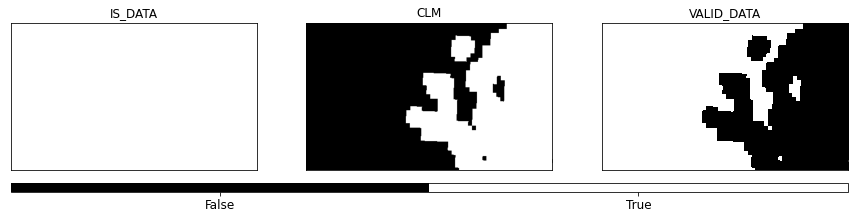

In [6]:
ts_idx = 5

subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw=subplot_kw)

ax = axs[0]
ax.imshow(eop.mask['IS_DATA'][ts_idx].squeeze(), vmin=0, vmax=1, cmap='gray')
ax.set_title('IS_DATA')

ax = axs[1]
ax.imshow(eop.mask['CLM'][ts_idx].squeeze(), vmin=0, vmax=1, cmap='gray')
ax.set_title('CLM')

ax = axs[2]
im = ax.imshow(eop.mask['VALID_DATA'][ts_idx].squeeze(), vmin=0, vmax=1, 
               cmap=ListedColormap(['#000000', '#ffffff']), 
               norm=BoundaryNorm([-0.5, 0.5, 1.5], 2))
ax.set_title('VALID_DATA')

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.05, aspect=100)
cb.set_ticks([0,1])
cb.ax.set_xticklabels([False, True], fontsize=12);

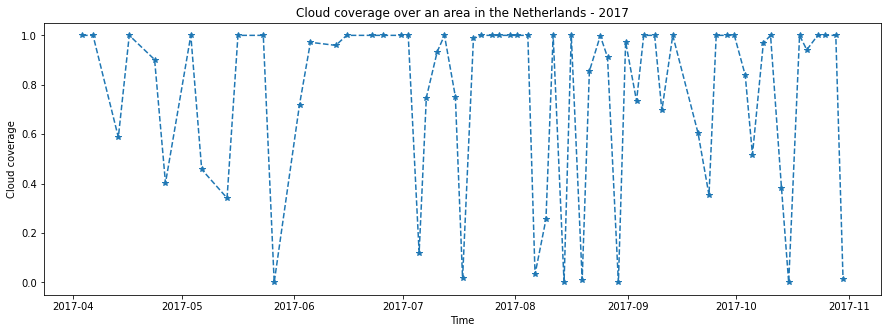

In [7]:
# cloud coverage
cc = [np.sum(x)/(np.prod(x.shape)) for x in eop.mask['CLM']]

fix, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(eop.timestamp, cc, '*--')
plt.ylabel('Cloud coverage')
plt.xlabel('Time')
plt.title('Cloud coverage over an area in the Netherlands - 2017');

Spatio-temporal features of a specific field

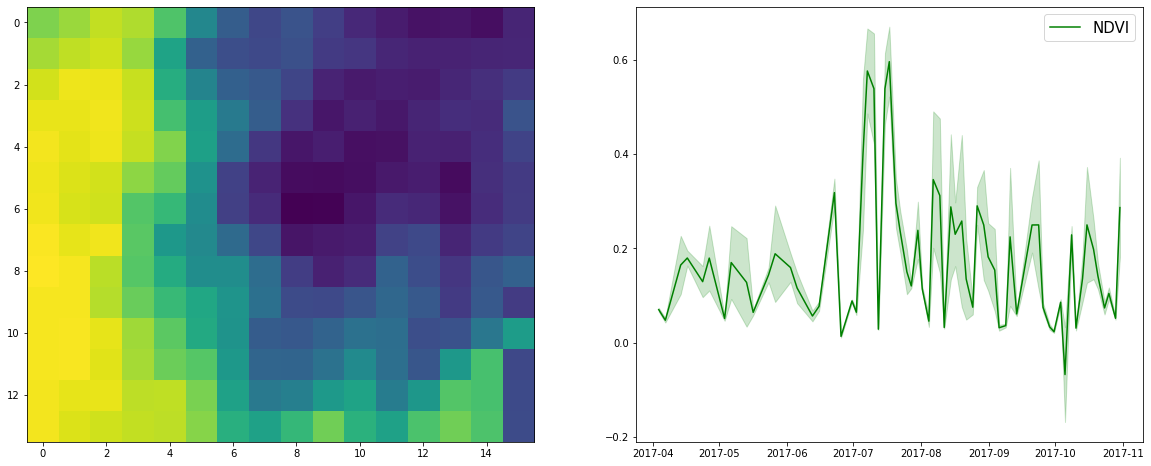

In [8]:
field_mask = (slice(None), slice(227, 241), slice(314,330))
ndvi_patch = eop.data['NDVI'][field_mask].squeeze(-1)

fix, axs = plt.subplots(1,2,figsize=(20,8))

ax = axs[0]
ax.imshow(ndvi_patch[20])
ax.set_aspect('auto')

ax = axs[1]
mean = np.mean(ndvi_patch, axis=(1,2))
std = np.std(ndvi_patch, axis=(1,2))
ax.plot(eop.timestamp, mean, color='g', label='NDVI')
ax.fill_between(eop.timestamp, mean-std, mean+std, alpha=0.2, color='g');
ax.set_aspect('auto')

plt.legend(fontsize=15);

### 2.1 Temporal indices for various temporally stacked NDVI features

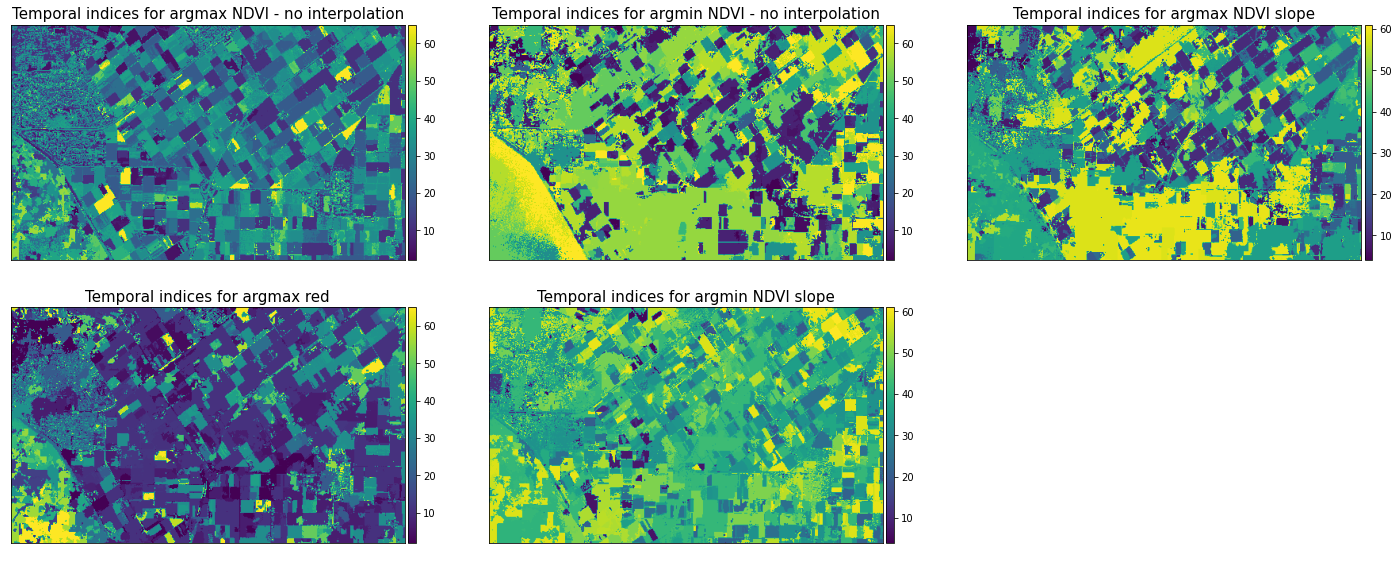

In [9]:
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,8), subplot_kw = subplot_kw)

ax = axs[0,0]
im = ax.imshow(eop.data_timeless['ARGMAX_NDVI'].squeeze())
ax.set_title("Temporal indices for argmax NDVI - no interpolation", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,1]
im = ax.imshow(eop.data_timeless['ARGMIN_NDVI'].squeeze())
ax.set_title("Temporal indices for argmin NDVI - no interpolation", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,2]
im = ax.imshow(eop.data_timeless['ARGMAX_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmax NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,1]
im = ax.imshow(eop.data_timeless['ARGMIN_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmin NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,0]
im = ax.imshow(eop.data_timeless['ARGMAX_B4'].squeeze())
ax.set_title("Temporal indices for argmax red", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()

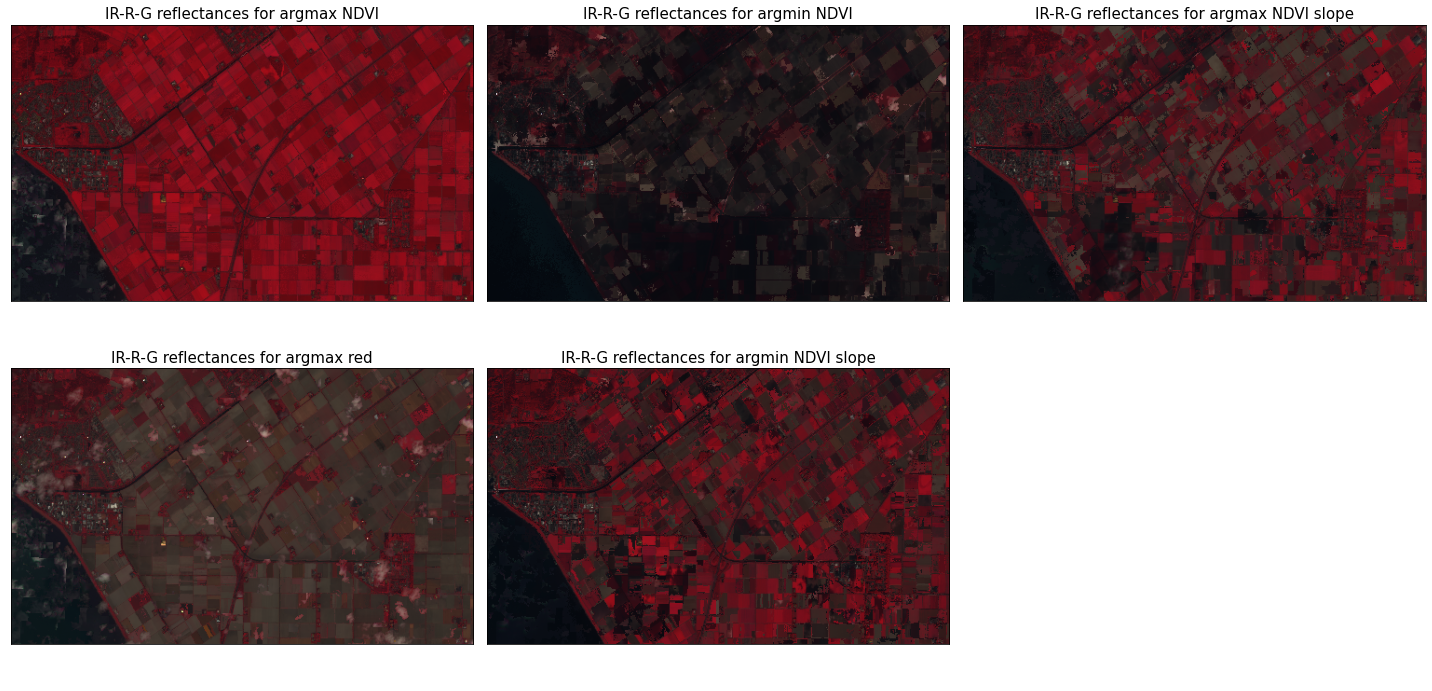

In [10]:
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,10), subplot_kw = subplot_kw)

ax = axs[0,0]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[2,1,0]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI", fontsize=15)

ax = axs[0,1]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[6,5,4]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI", fontsize=15)

ax = axs[0,2]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[10,9,8]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI slope", fontsize=15)

ax = axs[1,1]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[14,13,12]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI slope", fontsize=15)

ax = axs[1,0]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[18,17,16]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax red", fontsize=15);

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()

## 3. Repeat using interpolation

In [11]:
load_task = LoadTask('./stf/')

interp_ndvi = CubicInterpolation((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'))
interp_bands = CubicInterpolation((FeatureType.DATA, 'BANDS-S2-L1C'), mask_feature=(FeatureType.MASK, 'VALID_DATA'))

add_maxmin_ndvi = AddMaxMinTemporalIndicesTask(mask_data=False)
add_maxmin_red = AddMaxMinTemporalIndicesTask(data_feature='BANDS-S2-L1C', 
                                              data_index=3, 
                                              amax_data_feature='ARGMAX_B4',
                                              amin_data_feature='ARGMIN_B4',
                                              mask_data=False)
add_maxmin_ndvi_sl = AddMaxMinNDVISlopeIndicesTask()
add_stf = AddSpatioTemporalFeaturesTask()

In [12]:
workflow_with_interp = LinearWorkflow(
    load_task, 
    interp_ndvi, 
    interp_bands, 
    add_maxmin_ndvi,
    add_maxmin_red, 
    add_maxmin_ndvi_sl, 
    add_stf
)

result_with_interp = workflow_with_interp.execute({load_task:{'eopatch_folder':'eopatch'}})

In [13]:
eop_interp = result_with_interp.eopatch()
eop_interp

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(66, 297, 497, 13), dtype=float32)
    NDVI: numpy.ndarray(shape=(66, 297, 497, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(66, 297, 497, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=bool)
    dataMask: numpy.ndarray(shape=(66, 297, 497, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    ARGMIN_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    STF: numpy.ndarray(shape=(297, 497, 20), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  labe

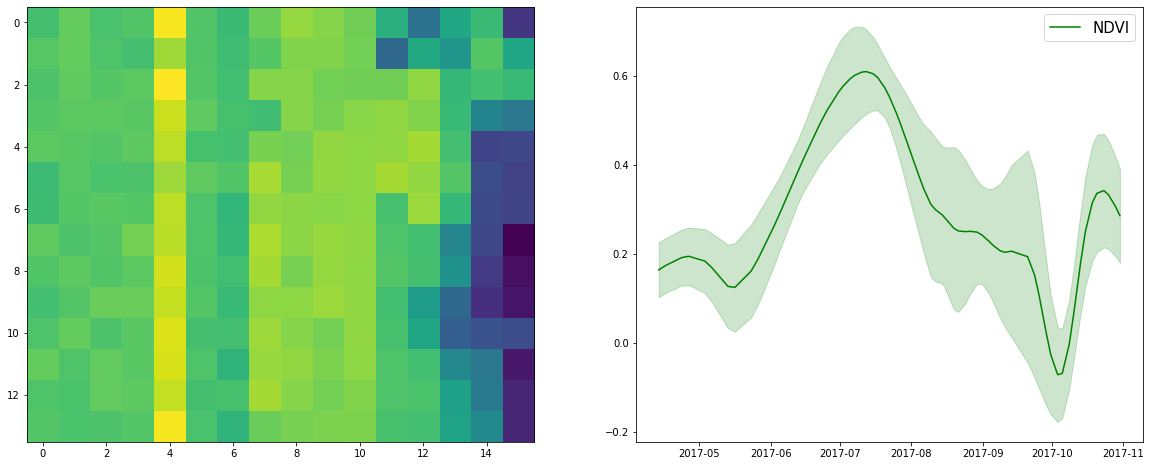

In [14]:
field_mask = (slice(None), slice(227, 241), slice(314,330))
ndvi_patch = eop_interp.data['NDVI'][field_mask].squeeze(-1)

fix, axs = plt.subplots(1,2,figsize=(20,8))

ax = axs[0]
ax.imshow(ndvi_patch[20])
ax.set_aspect('auto')

ax = axs[1]
mean = np.mean(ndvi_patch, axis=(1,2))
std = np.std(ndvi_patch, axis=(1,2))
ax.plot(eop_interp.timestamp, mean, color='g', label='NDVI')
ax.fill_between(eop_interp.timestamp, mean-std, mean+std, alpha=0.2, color='g');
ax.set_aspect('auto')

plt.legend(fontsize=15);

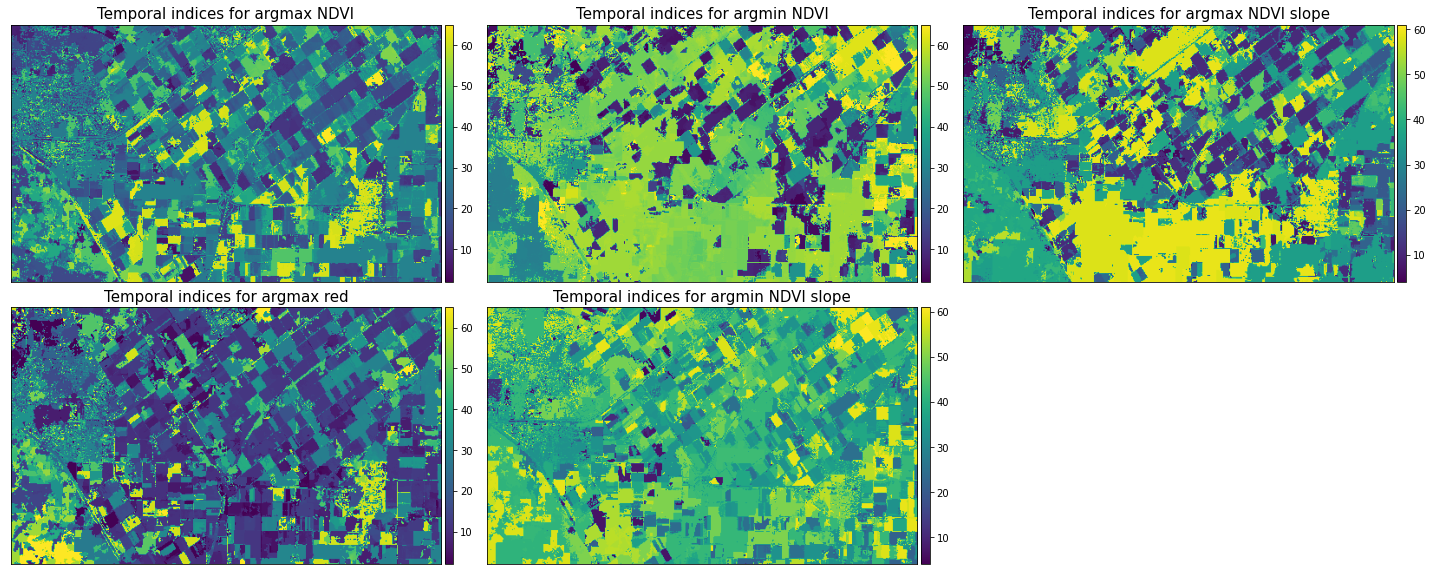

In [15]:
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,8), subplot_kw = subplot_kw)

ax = axs[0,0]
im = ax.imshow(eop_interp.data_timeless['ARGMAX_NDVI'].squeeze())
ax.set_title("Temporal indices for argmax NDVI", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,1]
im = ax.imshow(eop_interp.data_timeless['ARGMIN_NDVI'].squeeze())
ax.set_title("Temporal indices for argmin NDVI", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,2]
im = ax.imshow(eop_interp.data_timeless['ARGMAX_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmax NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,1]
im = ax.imshow(eop_interp.data_timeless['ARGMIN_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmin NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,0]
im = ax.imshow(eop_interp.data_timeless['ARGMAX_B4'].squeeze())
ax.set_title("Temporal indices for argmax red", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()

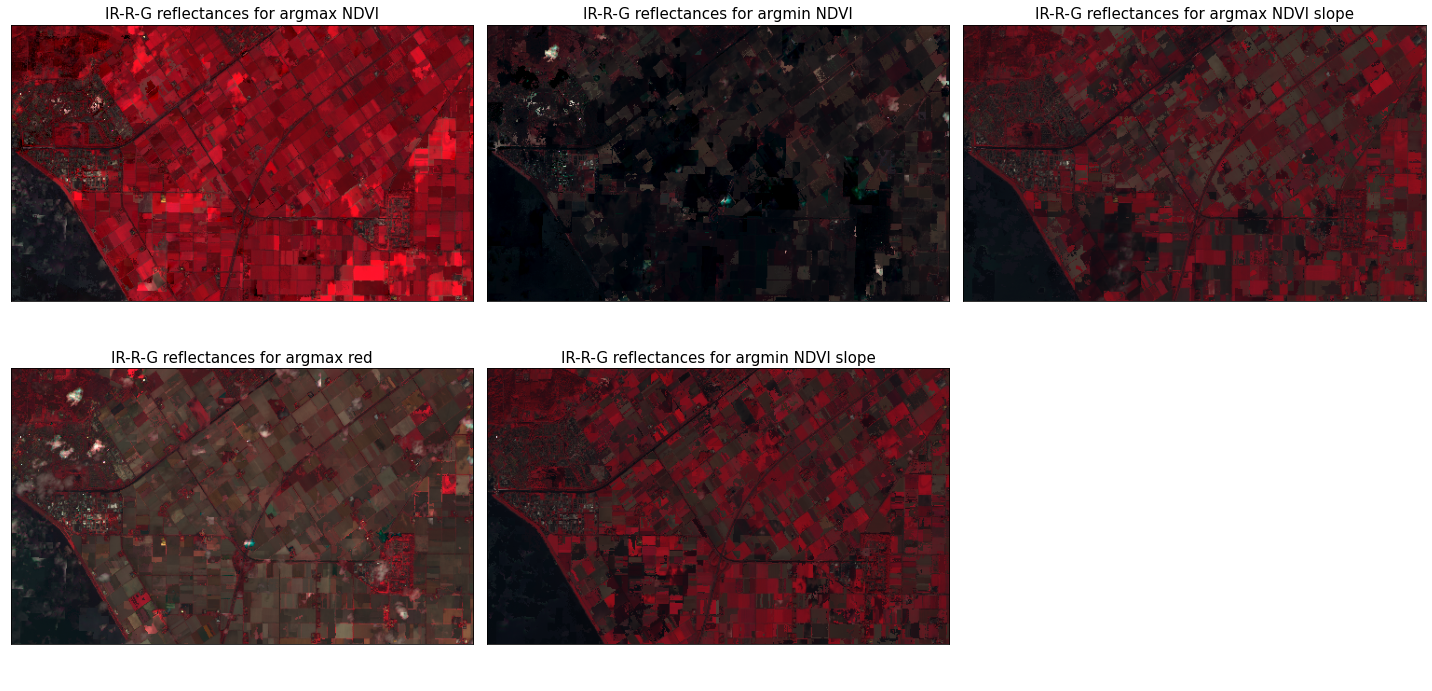

In [16]:
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,10), subplot_kw = subplot_kw)

ax = axs[0,0]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[2,1,0]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI", fontsize=15)

ax = axs[0,1]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[6,5,4]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI", fontsize=15)

ax = axs[0,2]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[10,9,8]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI slope", fontsize=15)

ax = axs[1,1]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[14,13,12]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI slope", fontsize=15)

ax = axs[1,0]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[18,17,16]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax red", fontsize=15);

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()